In [1]:
import os
import sys
import numpy as np
import math
from scipy.sparse.csgraph import laplacian
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats


cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster

## Prepare the Laplacian

In [2]:
state_dset = pd.read_csv(os.path.join(par,'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)
s_adj = pd.read_csv(os.path.join(par, "collected_data/state_adjacency.csv"), index_col = 0)
state_adj = pd.DataFrame(columns = state_dset.dataframe.columns, index = state_dset.dataframe.columns)

In [3]:
state_map = gp.read_file('US_States_geojson.json')
state_caps = pd.read_csv(os.path.join(par, "collected_data/us_state_capitals.csv"))

In [4]:
for ind in s_adj.index:
    st = s_adj.loc[ind,'state']
    ad = s_adj.loc[ind, 'adj']
    dist = s_adj.loc[ind, 'distance']
    state_adj.loc[st,ad] = 1
state_adj = state_adj.replace(np.nan, 0)

In [5]:
L = np.array(laplacian(state_adj))
I = np.identity(len(L))

## NMF for comparison

In [6]:
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [7]:
# ia0 and normalize:
state_iso = state_dset.known_iso()
#normy = state_iso.normalizer()

In [8]:
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [9]:
nmfed = nmf_cluster(state_norm.dataframe, 4, clusters=None, cluster_method='kmeans', num_outliers=None)

C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figu

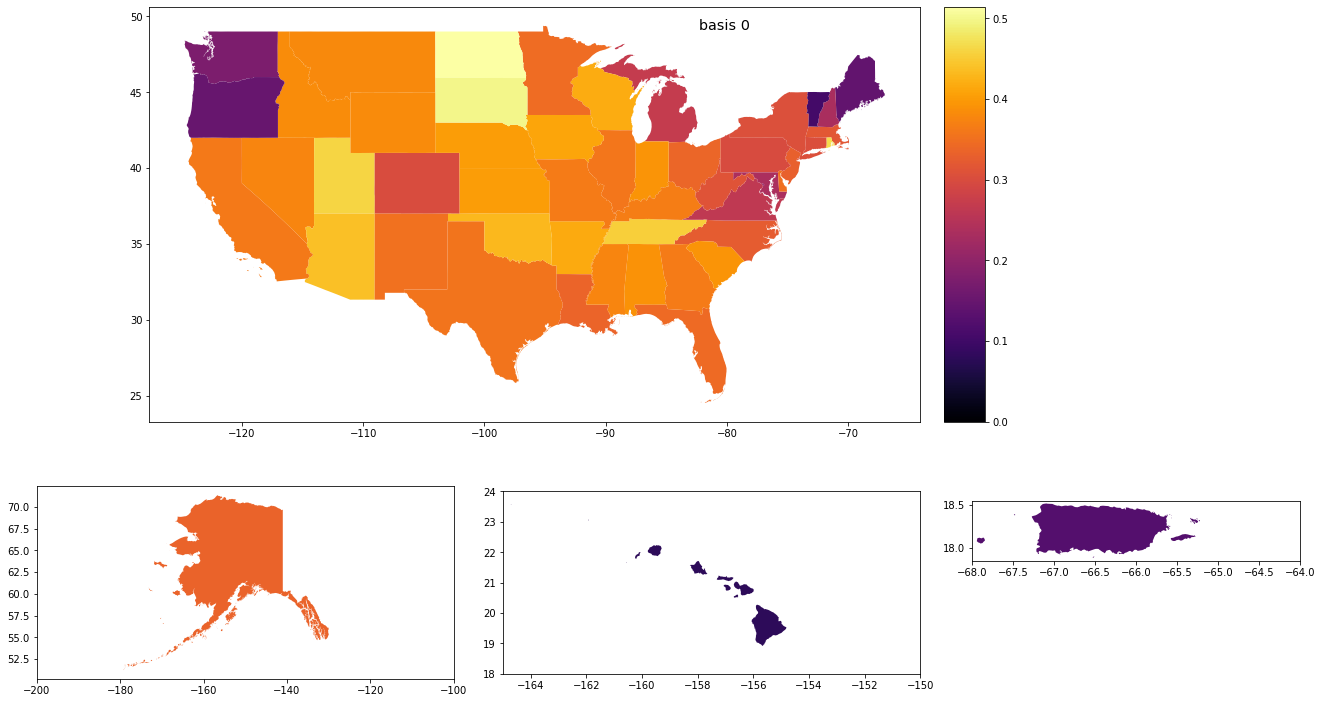

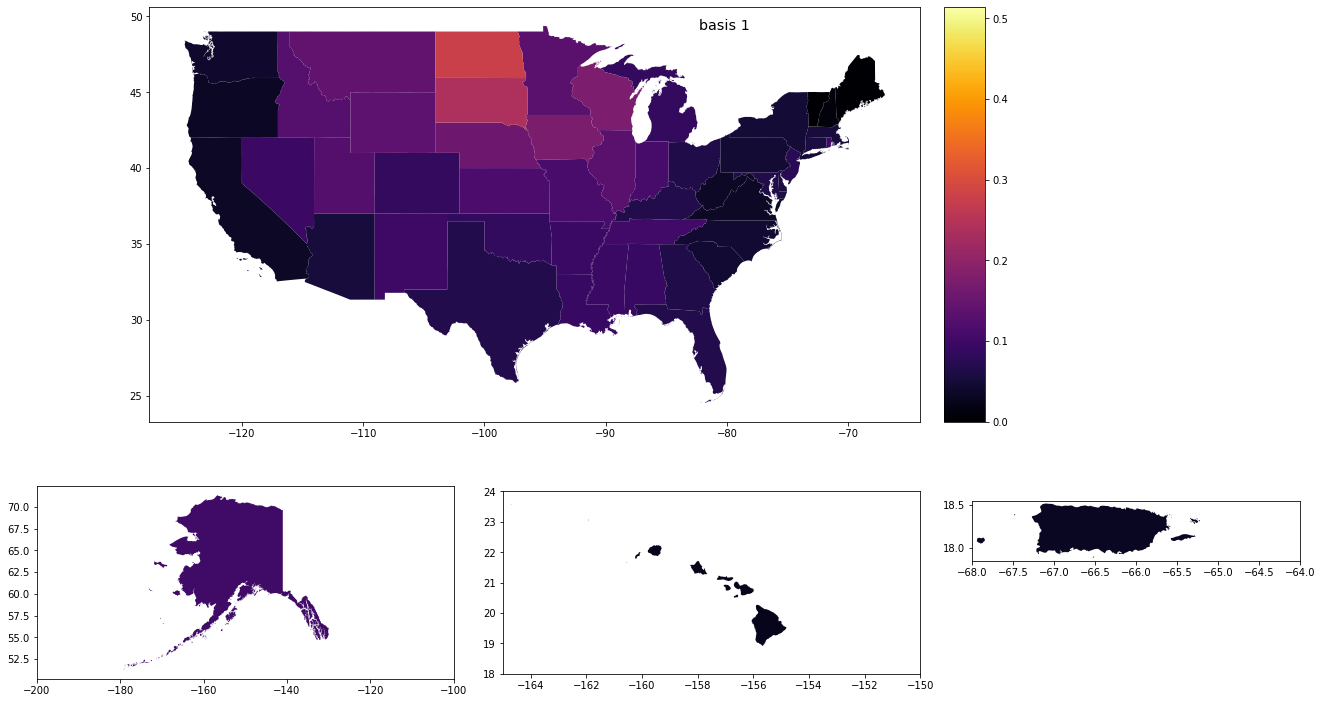

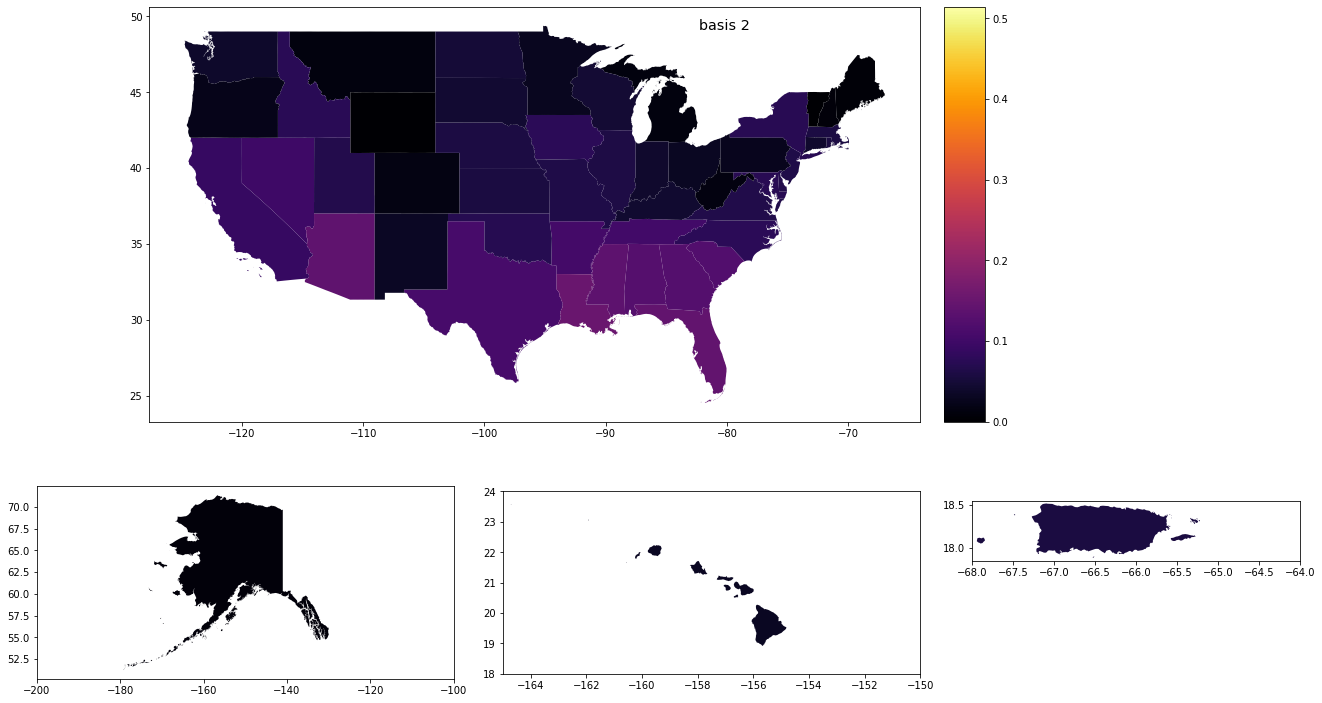

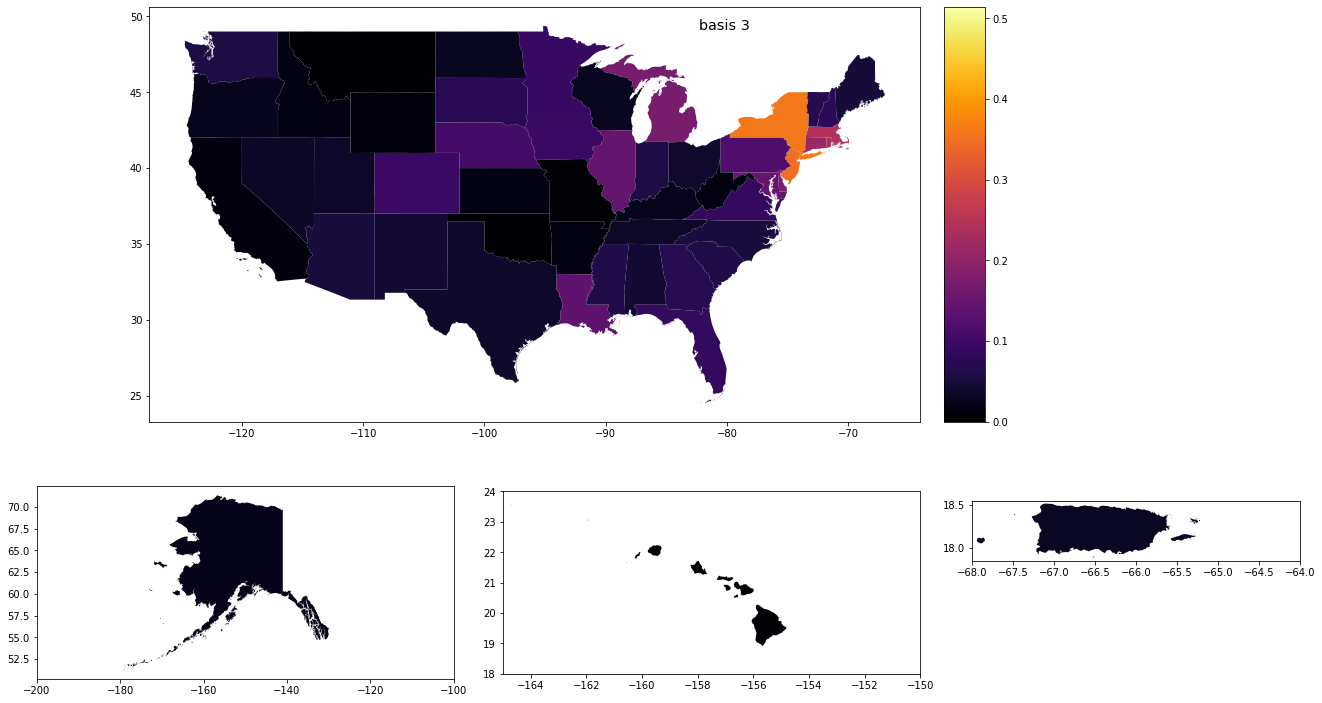

In [10]:
nmfed.state_map_basis()

In [11]:
nmfed.y_table.columns = state_norm.dataframe.columns

## Tune for Lambda

In [12]:
lambd = 3
Kinv = I + lambd * L
K = np.linalg.inv(Kinv)

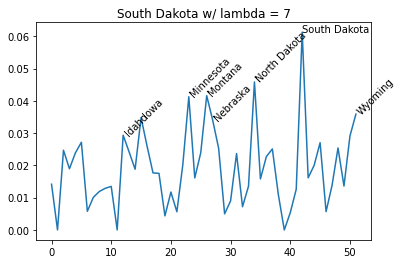

In [32]:
diff = pd.DataFrame(K, columns = state_adj.columns, index = state_adj.index)

state = 'South Dakota'
quant = diff.loc[:,state].quantile(0.85)
gep = diff.loc[:,state]
gep.index = range(len(gep.index))
cords = gep.loc[gep >= quant]

diff.loc[:,state].plot()
for point in cords.index:
    if diff.index[point] != state:
        plt.annotate(diff.index[point], (point, cords.loc[point]), rotation=45)
    else:
        plt.annotate(diff.index[point], (point, cords.loc[point]))
plt.title(state + ' w/ lambda = ' + str(lambd))
plt.show()

<ipython-input-33-229b0dba0d4c>:7: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%")


(-200.0, -25.0)

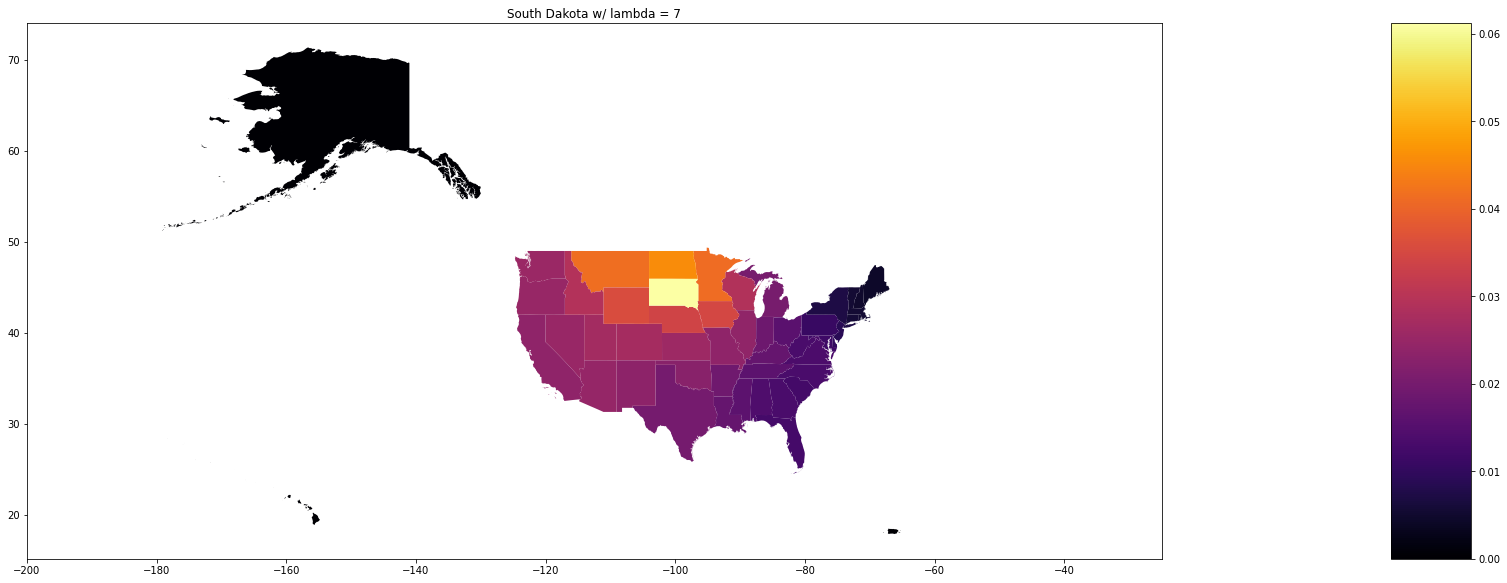

In [33]:
color_col = []
for state2 in state_map.NAME:
    color_col.append(diff.loc[state2,state])
state_map['cluster'] = color_col
fig,ax = plt.subplots(1,1,figsize = (30,30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%") 
state_map.plot(column = "cluster", ax = ax,cax=cax, cmap = 'inferno', legend = True)
ax.set_title(state + ' w/ lambda = ' + str(lambd))
ax.set_xlim(-200,-25)

In [15]:
x = range(1,100)
y = []
for beta in range(1,100):
    Kinv_i = I + beta * L
    K_i = np.linalg.inv(Kinv_i)
    diffy = pd.DataFrame(K_i, columns = state_adj.columns, index = state_adj.index)
    y.append(diffy.std().mean())

Text(0.5, 1.0, 'Average standard deviation for lambda = x')

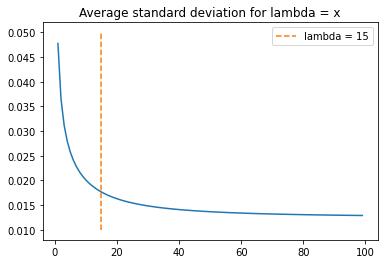

In [16]:
choice = 15
plt.plot(x,y)
plt.vlines(x=choice, ymin=0.01, ymax= 0.05, color="tab:orange", linestyle='dashed', label="lambda = " + str(choice))
plt.legend()
plt.title("Average standard deviation for lambda = x")

## Correlation between K and NMF

In [17]:
nmfed.y_table

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
basis 0,0.390952,0.333858,0.438719,0.417029,0.362228,0.301305,0.304096,0.350001,0.202072,0.344478,...,0.499470,0.454517,0.357412,0.460923,0.106427,0.262463,0.175897,0.312136,0.418367,0.382587
basis 1,0.091176,0.101424,0.053160,0.092845,0.035130,0.087487,0.056642,0.056517,0.059874,0.068177,...,0.237301,0.103088,0.067342,0.125238,0.000000,0.034454,0.041332,0.035525,0.175199,0.135888
basis 2,0.128161,0.009032,0.139553,0.105538,0.088714,0.016985,0.040311,0.066942,0.079530,0.143705,...,0.044300,0.103854,0.110342,0.067179,0.000000,0.065438,0.038560,0.015731,0.046976,0.000000
basis 3,0.046138,0.022577,0.053416,0.017407,0.013941,0.093996,0.214552,0.175019,0.211711,0.084661,...,0.074763,0.034481,0.039372,0.037553,0.068592,0.088356,0.060780,0.014996,0.028613,0.010696


In [30]:
x2 = range(1,50)
wave = 1
glob_max = -1
glob_y = []
glob_state = None
glob_lambd = 1


for geo_loc in nmfed.y_table.columns:
    y2 = []
    beta_best = 1
    corr_max = -1
    #geo_loc = 'Florida'
    
    for beta in x2:
        Kinv_i = I + beta * L
        K_i = np.linalg.inv(Kinv_i)
        diffy = pd.DataFrame(K_i, columns = state_adj.columns, index = state_adj.index)
        corr = stats.pearsonr(np.array(diffy.loc[:,geo_loc]), np.array(nmfed.y_table.iloc[wave,:]))

        if corr[0] > corr_max:
            beta_best = beta
            corr_max = corr[0]

        y2.append(corr[0])
        
    if max(y2) > glob_max:
        glob_max = max(y2)
        glob_y = y2
        glob_state = geo_loc
        glob_lambd = beta_best

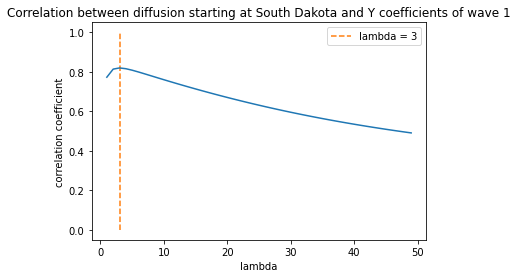

In [31]:
plt.plot(x2,glob_y)
plt.vlines(x=glob_lambd, ymin=0, ymax= 1, color="tab:orange", linestyle='dashed', label="lambda = " + str(glob_lambd))
plt.legend()
plt.title("Correlation between diffusion starting at " + str(glob_state) + " and Y coefficients of wave " + str(wave))
plt.xlabel('lambda')
plt.ylabel('correlation coefficient')
plt.show()

## D K^-1

In [34]:
D = state_norm.dataframe

In [35]:
betab  = 1
K1 = pd.DataFrame(I + betab * L)

In [36]:
K1

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,6.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
9,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
M = pd.DataFrame(np.dot(D, K1))

<AxesSubplot:>

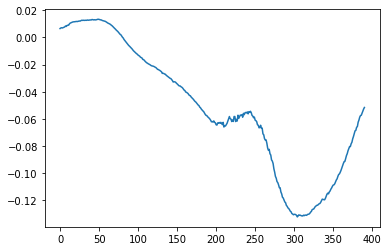

In [38]:
M.loc[:,5].plot()

<AxesSubplot:>

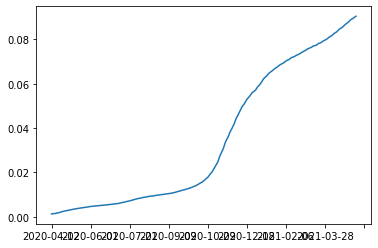

In [39]:
D.iloc[:,5].plot()

In [91]:
M

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-0.000101,0.000372,-0.001159,-0.004884,0.000539,0.006517,-0.002426,-0.003440,0.005992,0.000858,...,0.003344,0.001778,-0.003570,0.000505,-0.009436,-0.001705,0.003030,-0.002789,-0.001994,-0.001105
1,-0.000096,0.000379,-0.001197,-0.004821,0.000570,0.006940,-0.001464,-0.003425,0.006159,0.000893,...,0.004340,0.001559,-0.003642,0.000469,-0.009867,-0.001615,0.003016,-0.003052,-0.002191,-0.001315
2,-0.000150,0.000390,-0.001297,-0.004901,0.000646,0.007128,-0.001896,-0.003393,0.006457,0.000824,...,0.005144,0.001494,-0.003717,0.000408,-0.010403,-0.001569,0.003048,-0.003219,-0.002388,-0.001497
3,-0.000050,0.000401,-0.001335,-0.004984,0.000724,0.006956,-0.001879,-0.003473,0.006918,0.000854,...,0.006470,0.001181,-0.003755,0.000567,-0.011337,-0.001690,0.003092,-0.003322,-0.002508,-0.001693
4,-0.000152,0.000410,-0.001235,-0.005271,0.000766,0.007231,-0.001678,-0.003968,0.007399,0.000874,...,0.007467,0.001439,-0.003758,0.000687,-0.012044,-0.001878,0.003056,-0.003626,-0.002587,-0.001946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.101359,0.093536,0.206976,0.141338,0.113601,-0.057347,0.035615,0.153946,0.051725,0.101907,...,0.294366,0.324388,0.082091,0.258163,-0.127902,-0.002413,0.010897,0.082021,0.149144,0.031529
387,0.100928,0.093662,0.206900,0.141447,0.113403,-0.055820,0.035600,0.154107,0.051904,0.102310,...,0.295212,0.324377,0.082050,0.257867,-0.128081,-0.002519,0.011165,0.082511,0.149070,0.031399
388,0.101134,0.093864,0.206837,0.141688,0.113097,-0.054347,0.035759,0.154334,0.051927,0.102693,...,0.295037,0.324712,0.082172,0.258079,-0.128116,-0.002676,0.011383,0.083188,0.148880,0.031348
389,0.101141,0.093996,0.206615,0.141592,0.112965,-0.052776,0.036076,0.154526,0.051897,0.103093,...,0.294718,0.325390,0.082360,0.258083,-0.128293,-0.002831,0.011563,0.083761,0.148593,0.031608
